# <font color=#09A617 > <center> Analyze A/B Test Results </center> </font>

## <font color=#197521 > Table of Contents </font>
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

#### <font color=#197521 > Project Introduction </font>
In this project, we will be working to understand the results of an A/B test run by an e-commerce website. The company has developed a new web page in order to try and increase the number of users who "convert," meaning the number of users who decide to pay for the company's product. The goal is to work through this notebook to help the company understand if they should implement this new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability


##### <font color=#197521 >  Probability  Questions</font>

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure we get the same results on every run
random.seed(42)

`1.` Reading in the `ab_data.csv` data and storing it in `df`.  

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df.query('converted == 1')['user_id'].nunique()/df['user_id'].nunique()

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df.query('group != "treatment" & landing_page == "new_page"').shape[0] + df.query('group == "treatment" & landing_page != "new_page"').shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. We should remove these rows.

In [8]:
df2 = df[((df['group']=='treatment') & (df['landing_page']=='new_page')) |((df['group']=='control') & (df['landing_page']=='old_page')) ] 

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

a. How many unique **user_id**s are in **df2**?

In [10]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[(df2['user_id'].duplicated())]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [13]:
len(df2)

290585

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2 = df2.drop_duplicates(subset=['user_id'])

In [15]:
len(df2)

290584

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [19]:
df2.query('landing_page == "new_page"').shape[0]/df2.shape[0]

0.5000619442226688

e. Consider results from a. through d. above, do we think there is sufficient evidence to say that the new treatment page leads to more conversions?

**Without Hypothesis testing, we can not say whether the new treatment page leads to more conversions or not. In order to see whether there is a statistically significant difference in conversions for the new and old page, we can try the following two methods:**
1. Using Confidence Intervals.
2. Simulating from the null hypothesis
**We try using confidence intervals in this section**

In [20]:
control_mean = []
treatment_mean = []
diff = []

for i in range(10000):
    boot_sample = df2.sample(200, replace=True)
    control_mean.append(boot_sample[boot_sample['group']=='control']['converted'].mean())
    treatment_mean.append(boot_sample[boot_sample['group']=='treatment']['converted'].mean())
    mean_control= boot_sample[boot_sample['group']=='control']['converted'].mean()
    mean_treatment = boot_sample[boot_sample['group']=='treatment']['converted'].mean()
    diff.append(mean_treatment-mean_control)

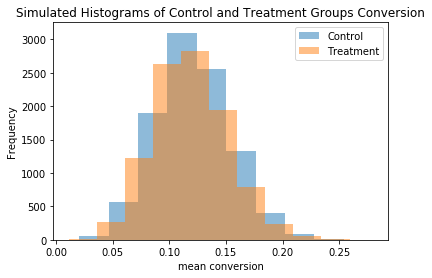

In [58]:
plt.hist(control_mean, alpha = 0.5,label="Control");
plt.hist(treatment_mean, alpha = 0.5,label="Treatment");
plt.xlabel('mean conversion')
plt.ylabel('Frequency')
plt.title('Simulated Histograms of Control and Treatment Groups Conversion')
plt.legend(loc="upper right");

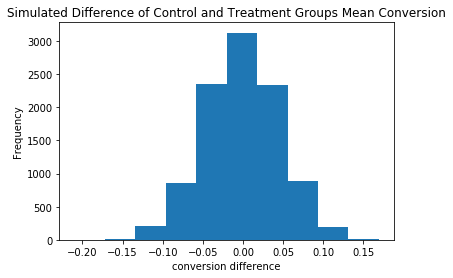

In [54]:
plt.hist(diff);
plt.xlabel('conversion difference')
plt.ylabel('Frequency')
plt.title('Simulated Difference of Control and Treatment Groups Mean Conversion');

In [23]:
np.percentile(diff, 2.5), np.percentile(diff, 97.5)

(-0.09436237564063912, 0.08922305764411029)

**A 95% confidence interval for the difference between the mean conversion of the new and old page contains zero. Therefore, we fail to reject the null hypothesis. There is no statistically significant difference in conversion between the two pages. We can see that from the histogram of the two versions as well.**

<a id='ab_test'></a>
### Part II - A/B Test


<a id='ab_test'></a>
#### <font color=#197521 > A/B Test </font>

Because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider we need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**$$H_{0}:p_{old}\geq p_{new}$$**
**$$H_{1}:p_{old} < p_{new}$$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>


a. What is the **convert rate** for $p_{new}$ under the null? 

In [26]:
p_new_null = df2['converted'].mean()
p_new_null

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [27]:
p_old_null = df2['converted'].mean()
p_old_null

0.11959708724499628

c. What is $n_{new}$?

In [30]:
n_new = df2.query('landing_page =="new_page"').shape[0]
n_new

145310

d. What is $n_{old}$?

In [31]:
n_old = df2.query('landing_page =="old_page"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [37]:
new_page_converted = np.random.choice([0,1],size=n_new,p=[(1-p_new_null),p_new_null])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [40]:
old_page_converted = np.random.choice([0,1],size=n_old,p=[(1-p_old_null),p_old_null])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [41]:
new_page_converted.mean()-old_page_converted.mean()

-8.473329784031147e-05

In [43]:
new_page_converted.mean()

0.11970958640148648

In [44]:
old_page_converted.mean()

0.11979431969932679

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [47]:
p_diff = []

for i in range(10000):
    new_page_converted = np.random.choice([0,1],size=n_new,p=[(1-p_new_null),p_new_null])
    old_page_converted = np.random.choice([0,1],size=n_old,p=[(1-p_old_null),p_old_null])
    p_diff.append(new_page_converted.mean()-old_page_converted.mean())

p_diff = np.array(p_diff)

i. Plot a histogram of the **p_diffs**.

In [63]:
obs_difference = df2.query('group == "treatment"')['converted'].mean() - df2.query('group == "control"')['converted'].mean()

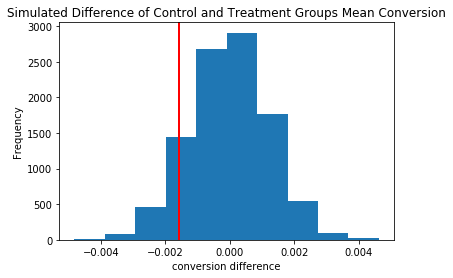

In [62]:
plt.hist(p_diff);
plt.xlabel('conversion difference')
plt.ylabel('Frequency')
plt.title('Simulated Difference of Control and Treatment Groups Mean Conversion')
plt.axvline(x=obs_difference, color='r', linewidth=2);

**This is what we expected. The difference contains zero as there does not appear to be a significant improvement in conversion rate on the new page.**

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [65]:
null_vals = p_diff
(p_diff>obs_difference).mean()

0.8984

**We just calculated the p-value for a one-tailed test at significant level of 0.05. With p-value of 0.898 at this significance level, we fail to reject the null hypothesis. There is not sufficient evidence to say that there is a difference between the conversion rate of the two pages.**

calculating the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [67]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page" & converted == 1').shape[0]
convert_new = df2.query('landing_page == "new_page" & converted == 1').shape[0]
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

In [69]:
convert_old, n_old, convert_new, n_new

(17489, 145274, 17264, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.

In [72]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')

z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**In order to use the z_score, we need to get the z critical at 0.05 alpha which is 1.645 for a one tailed z-test. z_score is smaller that z_critical and it means we fail to reject the null hypothesis. Both this and the obtained p_value is aligned with the results of bootstrapping.**

<a id='regression'></a>
### Part III - A regression approach


#### <font color=#197521 > Regression Approach for A/B testing </font>

`1.` The result we acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, we should perform logistic regression.

**Logistic Regression**

To go above and beyond, you may try to add the influences associated with time on conversion. In adding this variable to your analysis, it would be best to create dummy variables for different aspects of the time. Correctly coding and interpreting the results related to time along with the existing effects would benefit the analysis.